In [1]:
import numpy as np
import matplotlib.pyplot as plt 

import pandas as pd  
import seaborn as sns

boston = pd.read_csv('Boston.csv')
boston.head()

crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

    black  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2

In [2]:
print(boston.describe())
# check for missing values in all the columns
boston.isnull().sum()

             crim          zn       indus        chas         nox          rm  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              age         dis         rad         tax     ptratio       black  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.1057

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

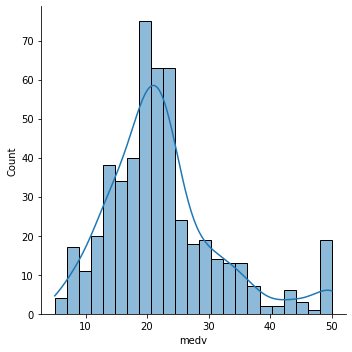

1.7583188871696095e-20


In [3]:
# plot a histogram showing the distribution of the target values
sns.displot(boston['medv'], kde=True)
plt.show()

# statistical test
# p-value >= 0.05 means that the distribution is a normal distribution
from scipy import stats
_, p = stats.normaltest(boston['medv'])
print(p)

0.1046886692817602


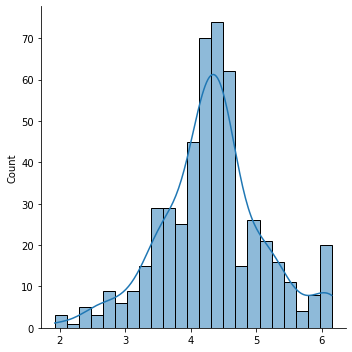

In [4]:
# y - transformation (box cox)
from scipy.stats import boxcox
y_bc, lambda_bc = boxcox(boston['medv'])
_, p = stats.normaltest(y_bc)
print(p)
sns.displot(y_bc, kde=True)

### Correlation matrix

<AxesSubplot:>

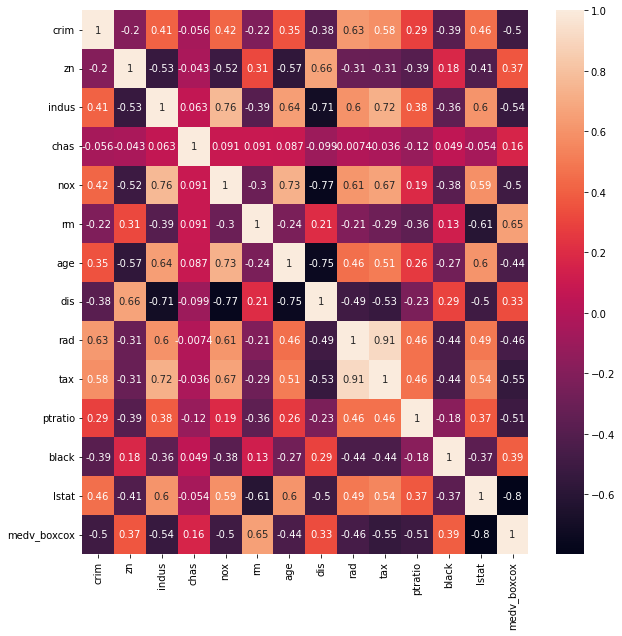

In [5]:
boston['medv_boxcox']=y_bc
del boston['medv']
# compute the pair wise correlation for all columns  
correlation_matrix = boston.corr()
# use the heatmap function from seaborn to plot the correlation matrix
# Manipulate figsize in inches for 
fig, ax = plt.subplots(figsize=(10,10))
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

**Observations**
- From the above coorelation plot we can see that **medv** is strongly correlated to **lstat**, **rm**
- **rad** and **tax** are stronly correlated, so we don't include this in our features together to avoid multi-colinearity

Feature ranking:
1. feature 12 (0.571671)
2. feature 5 (0.187518)
3. feature 7 (0.058690)
4. feature 0 (0.058230)
5. feature 4 (0.047488)
6. feature 10 (0.036242)
7. feature 11 (0.017130)
8. feature 9 (0.012743)
9. feature 6 (0.005091)
10. feature 2 (0.002358)
11. feature 8 (0.002353)
12. feature 3 (0.000354)
13. feature 1 (0.000133)


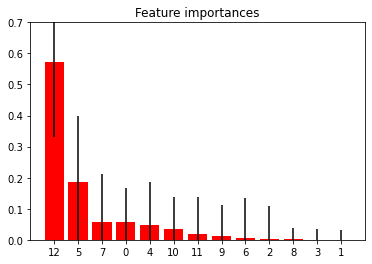

In [6]:
# Feature Importance using ExtraTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
# Build an estimator (forest of trees) and compute the feature importances
estimator = GradientBoostingRegressor(n_estimators=100, max_features='auto', random_state=0)

X = boston.values[:,0:-1]
y = boston.values[:,-1]

estimator.fit(X,y)
# Lets get the feature importances. 
# Features with high importance score higher.
importances = estimator.feature_importances_

std = np.std([tree[0].feature_importances_ for tree in estimator.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.ylim([0, 0.7])
plt.show()

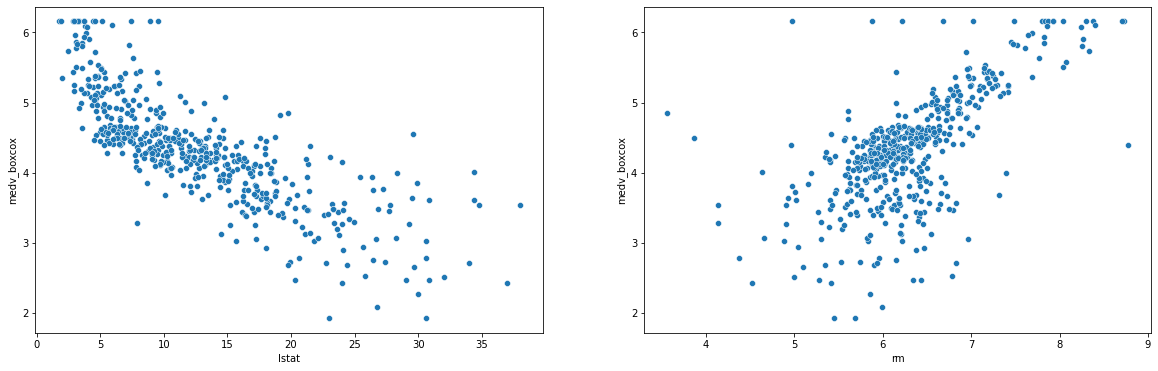

In [7]:
plt.figure(1,figsize=(20,6))
plt.subplot(121)
sns.scatterplot(data=boston, x = "lstat", y = "medv_boxcox")
plt.subplot(122)
sns.scatterplot(data=boston, x = "rm", y = "medv_boxcox")
plt.show()

**Prepare the data for training**

In [8]:
X = boston[['lstat', 'rm']]
y = boston['medv_boxcox']
X.describe()

lstat          rm
count  506.000000  506.000000
mean    12.653063    6.284634
std      7.141062    0.702617
min      1.730000    3.561000
25%      6.950000    5.885500
50%     11.360000    6.208500
75%     16.955000    6.623500
max     37.970000    8.780000

**Split the data into training and testing sets**

In [9]:
from sklearn.model_selection import train_test_split

# splits the training and test data set in 80% : 20%
# assign random_state to any value.This ensures consistency.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(404, 2)
(102, 2)
(404,)
(102,)


## Linear Regression

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lin_model = lr.fit(X_train, y_train)

# model evaluation for training set

y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
r2 = r2_score(y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set

y_test_predict = lin_model.predict(X_test)
# root mean square error of the model
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predict)))

# r-squared score of the model
r2 = r2_score(y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 0.44524281799133125
R2 score is 0.6791500044892885


The model performance for testing set
--------------------------------------
RMSE is 0.44178134046550205
R2 score is 0.6676469049002528


In [24]:
from scipy.special import inv_boxcox
# Model predictions are in the Box-Cox scale 
# We can transform them back to the original scale
# inverse Box Cox transformation
y_test_init = inv_boxcox(y_test, lambda_bc)
y_pred_init = inv_boxcox(y_test_predict, lambda_bc)
rmse_init = (np.sqrt(mean_squared_error(y_test_init, y_pred_init)))
r2_init = r2_score(y_test_init, y_pred_init)
print("The model performance for testing set (initial data scale)")
print("--------------------------------------")
print('RMSE is {}'.format(rmse_init))
print('R2 score is {}'.format(r2_init))

The model performance for testing set (initial data scale)
--------------------------------------
RMSE is 4.6033630675838815
R2 score is 0.7293408553865546


In [11]:
from sklearn import model_selection

# initialize k-folds cross-validator, with k=10
kfold = model_selection.KFold(n_splits=10)

# perform cross validation using k-folds cv
lr = LinearRegression()
rmse = model_selection.cross_val_score(lr, X_train, y_train, cv=kfold, scoring = 'neg_root_mean_squared_error')

print("Mean RMSE:", -rmse.mean())
print("Standard deviation RMSE:", rmse.std())

Mean RMSE: 0.44494177164127063
Standard deviation RMSE: 0.06456024696407048


In [12]:
# plotting the y_test vs y_pred
# ideally should have been a straight line
#plt.scatter(y_test, y_test_predict)
#plt.show()

#import plotly.express as px
#fig = px.scatter_3d(x=X_train['lstat'], y=X_train['rm'], z=y_train, height=500)
#fig.show()
#fig = px.scatter_3d(x=X_train['lstat'], y=X_train['rm'], z=y_train_predict, height=500)
#fig.show()

## Polynomial Regression

We can see that **lstat** doesn't vary exactly in a linear way. Let's apply the Polynomial Regression with **degree 2** and test.
To generate the higher order degrees, we use PolyniomialFeatures class from sklearn library.

In [13]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2)
  
# transform the features to higher degree features.
X_train_poly = poly_features.fit_transform(X_train)
print(X_train[0:5])
print(X_train_poly[0:5])
  
# fit the transformed features to Linear Regression
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
  
# predicting on training data-set
y_train_predicted = poly_model.predict(X_train_poly)
  
# predicting on test data-set
y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))
  
# evaluating the model on training dataset
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
r2_train = r2_score(y_train, y_train_predicted)
  
# evaluating the model on test dataset
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
r2_test = r2_score(y_test, y_test_predict)
  
print("The model performance for the training set")
print("-------------------------------------------")
print("RMSE of training set is {}".format(rmse_train))
print("R2 score of training set is {}".format(r2_train))
print("\n")
print("The model performance for the test set")
print("-------------------------------------------")
print("RMSE of test set is {}".format(rmse_test))
print("R2 score of test set is {}".format(r2_test))

     lstat     rm
33   18.35  5.701
283   3.16  7.923
418  20.62  5.957
502   9.08  6.120
402  20.31  6.404
[[  1.        18.35       5.701    336.7225   104.61335   32.501401]
 [  1.         3.16       7.923      9.9856    25.03668   62.773929]
 [  1.        20.62       5.957    425.1844   122.83334   35.485849]
 [  1.         9.08       6.12      82.4464    55.5696    37.4544  ]
 [  1.        20.31       6.404    412.4961   130.06524   41.011216]]
The model performance for the training set
-------------------------------------------
RMSE of training set is 0.39802168173371044
R2 score of training set is 0.743597855799234


The model performance for the test set
-------------------------------------------
RMSE of test set is 0.38518085923608414
R2 score of test set is 0.7473528604213808


**We can observe that the error has reduced after using polynomial regression as compared to linear regression**

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define a pipeline involving PolynomialFeatures and LinearRegression steps
pf = PolynomialFeatures()
lr = LinearRegression()
# name each step
pipe = Pipeline(steps=[("poly", pf), ("linear", lr)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = [
    { "poly__degree": [1, 2, 3, 4, 5], "poly__interaction_only": [True, False], "poly__include_bias": [True, False] },
    { "poly__degree": [1, 2, 3, 4], "poly__interaction_only": [True, False], "poly__include_bias": [True, False], "linear__fit_intercept": [True, False] }
]
# make grid object for GridSearchCV and fit the dataset
search = GridSearchCV(pipe, param_grid, scoring = 'neg_root_mean_squared_error', cv=10, n_jobs=-1)
search.fit(X_train, y_train)

# print results
print(" Results from Grid Search " ) 
print("\n The best estimator across ALL searched params:\n", search.best_estimator_) 
print("\n The best score across ALL searched params:\n", -search.best_score_) 
print("\n The best parameters across ALL searched params:\n", search.best_params_)
#search.cv_results_

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('poly',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('linear', LinearRegression())])

 The best score across ALL searched params:
 0.40204376705632133

 The best parameters across ALL searched params:
 {'poly__degree': 2, 'poly__include_bias': False, 'poly__interaction_only': True}


In [15]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

svr = SVR()
# model training
svr_model = svr.fit(X_train, y_train)

# model evaluation for testing set
y_test_predict = svr_model.predict(X_test)
# root mean square error of the model
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predict)))

# r-squared score of the model
r2 = r2_score(y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for testing set
--------------------------------------
RMSE is 0.3897794542299671
R2 score is 0.7412842450198232


In [16]:
from sklearn.model_selection import GridSearchCV

# use Support Vector Regressor as Machine Learning Model
svr = SVR()
# parameter grid (as described in previous slide)
parameter_grid = [
 {'C': [1, 10, 100, 1000], 'kernel': ['linear']}, 
 {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 {'C': [1, 10, 100, 1000], 'degree': [1, 2, 3, 4, 5, 6], 'kernel': ['poly']}
] 
# make grid_SVC object for GridSearchCV and fit the dataset
grid_SVR = GridSearchCV(estimator=svr, param_grid = parameter_grid, scoring = 'neg_root_mean_squared_error', n_jobs=-1) 
grid_SVR.fit(X_train, y_train)
# print results
print(" Results from Grid Search " ) 
print("\n The best estimator across ALL searched params:\n", grid_SVR.best_estimator_) 
print("\n The best score across ALL searched params:\n", grid_SVR.best_score_) 
print("\n The best parameters across ALL searched params:\n", grid_SVR.best_params_)
#grid_SVR.cv_results_

 Results from Grid Search 

 The best estimator across ALL searched params:
 SVR(C=1, kernel='poly')

 The best score across ALL searched params:
 -0.4058784550243251

 The best parameters across ALL searched params:
 {'C': 1, 'degree': 3, 'kernel': 'poly'}


In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

rf = RandomForestRegressor()
# model training
rf_model = rf.fit(X_train, y_train)

# model evaluation for testing set
y_test_predict = rf_model.predict(X_test)
# root mean square error of the model
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predict)))

# r-squared score of the model
r2 = r2_score(y_test, y_test_predict)

print("Model performance on testing dataset")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

Model performance on testing dataset
--------------------------------------
RMSE is 0.4589850760705825
R2 score is 0.6412580870278868


In [18]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
parameter_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
# make grid_SVC object for GridSearchCV and fit the dataset
grid_SVR = GridSearchCV(estimator=rf, param_grid = parameter_grid, scoring = 'neg_root_mean_squared_error', n_jobs=-1) 
grid_SVR.fit(X_train, y_train)
# print results
print(" Results from Grid Search " ) 
print("\n The best estimator across ALL searched params:\n", grid_SVR.best_estimator_) 
print("\n The best score across ALL searched params:\n", grid_SVR.best_score_) 
print("\n The best parameters across ALL searched params:\n", grid_SVR.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=60, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=466)

 The best score across ALL searched params:
 -0.3983982399159756

 The best parameters across ALL searched params:
 {'bootstrap': True, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 466}
